In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lbc.experiments.run_dpc import DPCRunner
from lbc.experiments.run_cpl import CPLRunner
from lbc.experiments.run_rlc import RLCRunner
from lbc.experiments.run_mpc import MPCRunner
from lbc.experiments.run_mpc_one_shot import MPCOneShotRunner
from lbc.experiments.run_rbc import RBCRunner

plt.rcParams["font.family"] = "Times New Roman"

%matplotlib inline
%load_ext autoreload

In [2]:
CURRENT_FILE_DIR = os.getcwd()
RESULTS_DIR = CURRENT_FILE_DIR.replace('notebooks',
                                       'lbc/experiments/results-')
RESULTS_DIR_RL = CURRENT_FILE_DIR.replace('notebooks',
                                          'lbc/policies/rlc_checkpoints/')

SAVE_FIG = False

In [3]:
def load_data(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

In [4]:
def get_loss(file_name):
    data = load_data(file_name)
    loss = np.array(data['train_data'][2]['losses'])
    return loss

In [5]:
select_exps = {'CPL-TOU-3-24-1-1.0.p': 'CPL-3',
               'CPL-TOU-6-24-1-1.0.p': 'CPL-6',
               'CPL-TOU-12-24-1-1.0.p': 'CPL-12',
               'DPC-TOU-3-0.001-512.p': 'DPC-3-1e-3',
               'DPC-TOU-6-0.001-512.p': 'DPC-6-1e-3',
               'DPC-TOU-12-0.001-512.p': 'DPC-12-1e-3',
               'DPC-TOU-24-0.00005-512.p': 'DPC-24-5e-5',
               'DPC-TOU-12-0.00005-512.p': 'DPC-12-5e-5',
               'DPC-TOU-6-0.00005-512.p': 'DPC-6-5e-5',
               'DPC-TOU-3-0.00005-512.p': 'DPC-3-5e-5'}

rl_exps = {'time_of_use/' + str(x) + '/progress.csv': 
           'RL-' + str(x) + '-5e-5' for x in [3, 6, 12]}
rl_exps.update({'full_versions/time_of_use/' + str(x) + '-lr1e-3/progress.csv':
                'RL-' + str(x) + '-1e-3' for x in [3, 6, 12]})

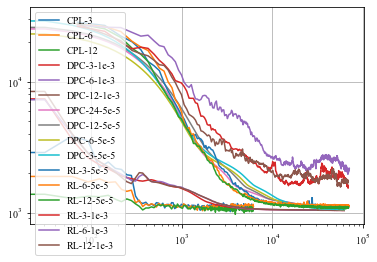

In [6]:
for exp in select_exps.keys():
    f_n = os.path.join(RESULTS_DIR + 'TOU', exp)
    dp = get_loss(f_n)
    plt.plot(31 * np.arange(len(dp)), dp, label=select_exps[exp])
for exp in rl_exps:
    rl_data = pd.read_csv(os.path.join(RESULTS_DIR_RL, exp))
    plt.plot(rl_data['episodes_total'],
             rl_data['episode_reward_mean'].to_numpy() * -1000,
             label=rl_exps[exp])
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [7]:
EXPS_MAP = {'1e-3': ['full_versions/time_of_use/' + str(x) + '-lr1e-3/progress.csv' for x in [3, 6, 12]],
            '5e-5': ['time_of_use/' + str(x) + '/progress.csv' for x in [3, 6, 12]]}

def get_rl_learning_curve(lr):
    assert lr in ['1e-3', '5e-5']
    exps = EXPS_MAP[lr]
    results = []
    for exp in exps:
        rl_data = pd.read_csv(os.path.join(RESULTS_DIR_RL, exp))
        results.append(rl_data['episode_reward_mean'].to_numpy() * -1000)
    min_len = min([len(x) for x in results])
    results = [x[:min_len] for x in results]
    results = np.array(results)
    
    return rl_data['episodes_total'][:min_len], np.mean(results, axis=0), np.std(results, axis=0)

In [8]:
def get_cpl_dpc_learning_curve(controller_type, lr=None):
    if controller_type == 'CPL':
        exps = ['CPL-TOU-3-24-1-1.0.p', 'CPL-TOU-6-24-1-1.0.p', 'CPL-TOU-12-24-1-1.0.p']
    elif controller_type == 'DPC' and lr == '1e-3':
        exps = ['DPC-TOU-3-0.001-512.p', 'DPC-TOU-6-0.001-512.p', 'DPC-TOU-12-0.001-512.p']
    elif controller_type == 'DPC' and lr == '5e-5':
        exps = ['DPC-TOU-3-0.00005-512.p', 'DPC-TOU-6-0.00005-512.p', 'DPC-TOU-12-0.00005-512.p']
        
    learning_curves = np.array([get_loss(os.path.join(RESULTS_DIR + 'TOU', x)) for x in exps])
    
    lc_mean = np.mean(learning_curves, axis=0)
    lc_std = np.std(learning_curves, axis=0)
    
    return lc_mean, lc_std

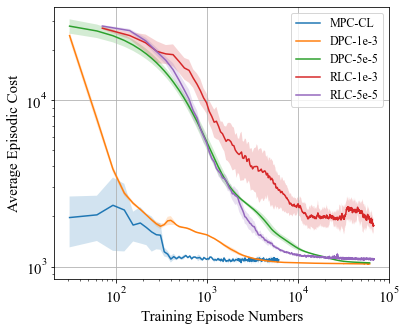

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

cpl_mean, cpl_std = get_cpl_dpc_learning_curve('CPL')
plt.plot(31 * (np.arange(200) + 1), cpl_mean, label='MPC-CL')
plt.fill_between(31 * (np.arange(200) + 1), cpl_mean - cpl_std, cpl_mean + cpl_std, alpha=0.2)

dpc_mean, dpc_std = get_cpl_dpc_learning_curve('DPC', '1e-3')
plt.plot(31 * (np.arange(2000) + 1), dpc_mean, label='DPC-1e-3')
plt.fill_between(31 * (np.arange(2000) + 1), dpc_mean - dpc_std, dpc_mean + dpc_std, alpha=0.2)

dpc_mean, dpc_std = get_cpl_dpc_learning_curve('DPC', '5e-5')
plt.plot(31 * (np.arange(2000) + 1), dpc_mean, label='DPC-5e-5')
plt.fill_between(31 * (np.arange(2000) + 1), dpc_mean - dpc_std, dpc_mean + dpc_std, alpha=0.2)

rl_x, rl_mean, rl_std = get_rl_learning_curve('1e-3')
plt.plot(rl_x, rl_mean, label='RLC-1e-3')
plt.fill_between(rl_x, rl_mean - rl_std, rl_mean + rl_std, alpha=0.2)

rl_x, rl_mean, rl_std = get_rl_learning_curve('5e-5')
plt.plot(rl_x, rl_mean, label='RLC-5e-5')
plt.fill_between(rl_x, rl_mean - rl_std, rl_mean + rl_std, alpha=0.2)

plt.xlabel('Training Episode Numbers', fontsize=15)
plt.ylabel('Average Episodic Cost', fontsize=15)

ax.tick_params(labelsize=15)

plt.legend(fontsize=12)

plt.yscale('log')
plt.xscale('log')
plt.grid()

if SAVE_FIG:
    plt.savefig('learning_curves.png', dpi=200)
    

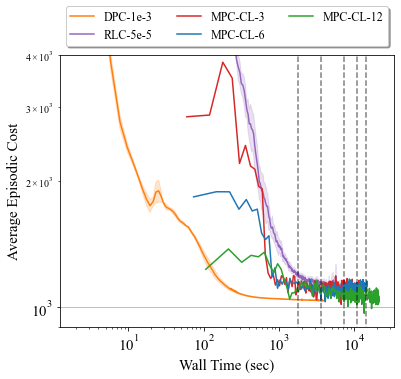

In [10]:
DPC_TOTAL_TIME = 3890.5
RL_TOTAL_TIME = 14400
CPL_TOTAL_TIME = {3: 11986.7, 6: 14740.3, 12: 21365.7}
    
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

dpc_mean, dpc_std = get_cpl_dpc_learning_curve('DPC', '1e-3')
plt.plot(DPC_TOTAL_TIME / 2000 * (np.arange(2000) + 1), dpc_mean, label='DPC-1e-3', color='tab:orange')
plt.fill_between(DPC_TOTAL_TIME / 2000 * (np.arange(2000) + 1),
                 dpc_mean - dpc_std, dpc_mean + dpc_std, alpha=0.2, color='tab:orange')

rl_x, rl_mean, rl_std = get_rl_learning_curve('5e-5')
n_rl_x = len(rl_x)
plt.plot(RL_TOTAL_TIME / n_rl_x * (np.arange(n_rl_x) + 1),
         rl_mean, label='RLC-5e-5', color='tab:purple')
plt.fill_between(RL_TOTAL_TIME / n_rl_x * (np.arange(n_rl_x) + 1),
                 rl_mean - rl_std, rl_mean + rl_std, color='tab:purple', alpha=0.2)

cpl_exps = {3: 'CPL-TOU-3-24-1-1.0.p', 6: 'CPL-TOU-6-24-1-1.0.p', 12: 'CPL-TOU-12-24-1-1.0.p'}
colors = {3: 'tab:red', 6: 'tab:blue', 12: 'tab:green'}

for la, exp in cpl_exps.items():
    cpl_curve = get_loss(os.path.join(RESULTS_DIR + 'TOU', exp))
    plt.plot(CPL_TOTAL_TIME[la] / 200 * (np.arange(200) + 1), cpl_curve, label='MPC-CL-' + str(la),
             color=colors[la])

for k in [0.5, 1, 2, 3, 4]:
    plt.plot([3600 * k, 3600 * k], [500, 5000], linestyle='dashed', color='k', alpha=0.5)

plt.xlabel('Wall Time (sec)', fontsize=15)
plt.ylabel('Average Episodic Cost', fontsize=15)

ax.tick_params(labelsize=15)
# plt.legend(loc='lower left', ncol=1, fontsize=12)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
           fancybox=True, shadow=True, ncol=3, fontsize=12)

plt.yscale('log')
plt.xscale('log', base=10)
# plt.xticks([3600*x for x in range(1, 7)], [str(x) + ':00' for x in range(1, 7)])
plt.ylim([900, 4000])
plt.grid(axis='y')

if SAVE_FIG:
    plt.savefig('learning_curves_time.png', dpi=200, bbox_inches = "tight")

### Observations:

1. ConvexMPCLayer has the highest sample efficiency, i.e., it requires the least amount of training samples to converge: with around 400 episodes of data. In addition, due to the MPC nature of the ConvexMPCLayer approach, at the beginning of the training phase when the terminal costs are not learned, the cost (around 2*10^3) is already lower than those of the RL and DPC controllers' (around 3*10^4). Note, the sample efficiency is different from the computational efficiency, i.e., fast to train. 

2. For RL and DPC controller training, we experimented with two different learning rates, i.e., 1e-3 and 5e-5. With the smaller learning rate, both RL and DPC controller converge with similar learning trajectories; with the larger learning rate, the learning process of the DPC controller can be accelerated (see "DPC-1e-3" vs. "DPC-5e-5" in Fig.X), however, the RL controller training experiences a slower convergence, and is harder to converge to the same cost level as using a smaller learning rate. The reason for causing this difference between DPC and RL is that at each training step, the model-based DPC can calculate exact gradients while RL's gradient estimation is noisy. Generally, when the estimated graident is less noisy (the DPC is an extreme case with no noise at all), the optimizer can take a larger learning step to achieve a better converging performance, see [] for an example.